### adaboost 算法

In [2]:
# 1.加载数据
from numpy import *

def loadSimpData():
    datMat = matrix([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [3]:
dataMat, classLabels = loadSimpData()
print(dataMat, classLabels)

[[1.  2.1]
 [2.  1.1]
 [1.3 1. ]
 [1.  1. ]
 [2.  1. ]] [1.0, 1.0, -1.0, -1.0, 1.0]


In [5]:
# 1-2. 从文件加载数据
def loadDataSet(fileName):      # general function to parse tab delimited floats
    numFeat = len(open(fileName).readline().split('\t'))  # get number of fields 
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

In [6]:
# 2. 判别方法
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):  # just classify the data
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1.0  # lower and equal --> lt
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1.0
    return retArray

In [8]:
# 3. 构建树墩：由于在单个属性值上划分
def buildStump(dataArr, classLabels, D):
    dataMatrix = mat(dataArr); labelMat = mat(classLabels).T
    m,n = shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = mat(zeros((m,1)))
    minError = inf #init error sum, to +infinity
    for i in range(n):#loop over all dimensions
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max();
        stepSize = (rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):#loop over all range in current dimension
            for inequal in ['lt', 'gt']: #go over less than and greater than
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)#call stump classify with i, j, lessThan
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr  #calc total error multiplied by D
                #print "split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError)
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [11]:
bestStump,minError,bestClasEst = buildStump(dataMat, classLabels, mat(ones((5, 1)) / 5))
print(bestStump, minError, bestClasEst)

{'dim': 0, 'thresh': 1.3, 'ineq': 'lt'} [[0.2]] [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [30]:
# 3.集成分类器
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = shape(dataArr)[0]
    D = mat(ones((m,1))/m)   # init D to all equal
    aggClassEst = mat(zeros((m,1)))
    for i in range(numIt):
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)  # build Stump
        # print(“D:",D.T）
        alpha = float(0.5*log((1.0-error)/max(error,1e-16)))#calc alpha, throw in max(error,eps) to account for error=0
        bestStump['alpha'] = alpha  
        weakClassArr.append(bestStump)                  #store Stump Params in Array
        # print("classEst: ",classEst.T)
        expon = multiply(-1*alpha*mat(classLabels).T,classEst) #exponent for D calc, getting messy
        D = multiply(D,exp(expon))                              #Calc New D for next iteration
        D = D/D.sum()
        # calc training error of all classifiers, if this is 0 quit for loop early (use break)
        aggClassEst += alpha*classEst
        # print("aggClassEst: ",aggClassEst.T)
        aggErrors = multiply(sign(aggClassEst) != mat(classLabels).T,ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ", errorRate)
        if errorRate == 0.0: 
            break
    return weakClassArr, aggClassEst

In [31]:
classifierArray, _ = adaBoostTrainDS(dataMat, classLabels, 9)
print(classifierArray)

total error:  0.2
total error:  0.2
total error:  0.0
[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


In [14]:
# 4. 测试用来预测
def adaClassify(datToClass, classifierArr):
    dataMatrix = mat(datToClass)  # do stuff similar to last aggClassEst in adaBoostTrainDS
    m = shape(dataMatrix)[0]
    aggClassEst = mat(zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(
            dataMatrix, 
            classifierArr[i]['dim'],
            classifierArr[i]['thresh'],
            classifierArr[i]['ineq'])  # call stump classify
        aggClassEst += classifierArr[i]['alpha']*classEst
        print(aggClassEst)
    return sign(aggClassEst)

In [16]:
adaClassify([0, 0], classifierArray)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [17]:
adaClassify([[5, 5], [0, 0]], classifierArray)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

### 马疝气病分析

In [18]:
#1. 加载数据
dataArr, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(dataArr, labelArr, 10)
print(classifierArray)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078
[{'dim': 9, 'thresh': 3.0, 'ineq': 'gt', 'alpha': 0.4616623792657674}, {'dim': 17, 'thresh': 52.5, 'ineq': 'gt', 'alpha': 0.31248245042467104}, {'dim': 3, 'thresh': 55.199999999999996, 'ineq': 'gt', 'alpha': 0.28680973201695786}, {'dim': 18, 'thresh': 62.300000000000004, 'ineq': 'lt', 'alpha': 0.23297004638939492}, {'dim': 10, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.19803846151213736}, {'dim': 5, 'thresh': 2.0, 'ineq': 'gt', 'alpha': 0.18847887349020628}, {'dim': 12, 'thresh': 1.2, 'ineq': 'lt', 'alpha': 0.1522736899747682}, {'dim': 7, 'thresh': 1.2, 'ineq': 'gt', 'alpha': 0.15510870821690512}, {'dim': 5, 'thresh': 0.0, 'ineq': 'lt', 'alpha': 0.13536197353

In [20]:
testArr, testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr, classifierArray)
print(prediction10)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [26]:
errArr = mat(ones((67, 1)))
error_num = errArr[prediction10 != mat(testLabelArr).T].sum()
err_rate = error_num / errArr.shape[0]
print(err_rate)

0.23880597014925373


In [34]:
# 2.画roc曲线
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0)  # cursor
    ySum = 0.0  # variable to calculate AUC
    numPosClas = sum(array(classLabels)==1.0)
    yStep = 1/float(numPosClas)
    xStep = 1/float(len(classLabels)-numPosClas)
    sortedIndicies = predStrengths.argsort()  # get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    # loop through all the values, drawing a line segment at each point
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        # draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0], cur[0]-delX], [cur[1], cur[1]-delY], c='b')
        cur = (cur[0]-delX, cur[1]-delY)
    ax.plot([0,1], [0,1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curve is: ", ySum * xStep)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


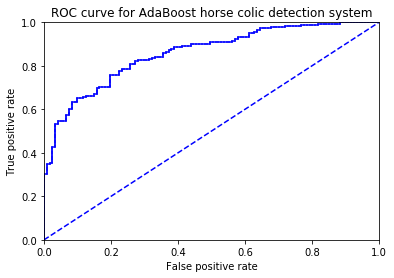

the Area Under the Curve is:  0.8582969635063604


In [35]:
dataArra, labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 10)
plotROC(aggClassEst.T, labelArr)